# Setup and install for test13

In [ ]:

import os
import re
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install gpflow
%pip install plotnine
%pip install plotly
%pip install keras_self_attention
%pip install keras_tuner
%pip install pycm

     |████████████████████████████████| 286 kB 13.6 MB/s 
  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=b433bf850c73637c563c4b906150ee52031f0a5b6d666c3fb0b4cc10803cd370
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention
     |████████████████████████████████| 98 kB 5.1 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 580 kB 33.9 MB/s 


In [ ]:
from plotnine import *
from plotnine.themes import *
import plotly as py
import plotly.graph_objs as go
import pandas as pd


In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp

_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [ ]:
paper_name = "test13"

In [ ]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/")



In [ ]:
data_location = f'/content/drive/MyDrive/data_papers/{paper_name}'

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute,Reshape, Lambda, RepeatVector, Input,Multiply
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import SimpleRNN, GRU, LeakyReLU
from tensorflow.keras.layers import Concatenate, Average 
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import  Bidirectional
from timeit import default_timer as timer
import h5py as h5
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import errno
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import random
import warnings
import gpflow
from gpflow.utilities import ops, print_summary, set_trainable
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter
import warnings
from functools import partial
from multiprocessing import Pool, cpu_count
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from tensorflow.keras import regularizers
import os
from collections import defaultdict
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import keras_tuner as kt

In [ ]:
# Run this cell to load the dataset
INPUT_DIM = 8    # 

hf_Train = h5.File(f'{data_location}/Fold_10_Train_Data_1000.h5', 'r')
hf_Test = h5.File(f'{data_location}/Fold_10_Test_Data_1000.h5', 'r')

X_train = hf_Train['Train_Data'] # Get train set
X_train = np.array(X_train)
Y_train = hf_Train['Label']      # Get train label
Y_train = np.array(Y_train)

X_test = hf_Test['Train_Data']     # Get test set
X_test = np.array(X_test)
Y_test = hf_Test['Label']       # Get test label
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train, 13)  # Process the label of tain
Y_test = to_categorical(Y_test, 13)    #  Process the label of te

def coShuffled_vectors(X,Y):
    if tf.shape(X)[0] ==  tf.shape(Y)[0]:
        test_idxs = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
        shuffled_test_idxs = tf.random.shuffle(test_idxs)
        return ( tf.gather(X, shuffled_test_idxs), tf.gather(Y, shuffled_test_idxs) )
    else:
        raise ValueError(f"0-dimension has to be the same {tf.shape(X)[0]} != {tf.shape(Y)[0]}")

X_test_shuffled, Y_test_shuffled = coShuffled_vectors(np.array(hf_Test['Train_Data']), to_categorical(np.array(hf_Test['Label']),13))
X_train_shuffled, Y_train_shuffled = coShuffled_vectors(np.array(hf_Train['Train_Data']), to_categorical(np.array(hf_Train['Label']),13))



In [ ]:
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if k in ('accuracy', 'val_accuracy')] 
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='upper right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()



In [ ]:

def get_layer_by_name(layers, name, return_first = True):
    matching_named_layers = [ l for l in layers if l.name==name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


def get_combined_features_from_models(
        to_combine, 
        X_train, Y_train, 
        X_test, Y_test,
        reverse_one_hot = False,
        normalize_X_func = None):
    
    models = dict()
    X_trains_out = []
    X_test_out = []
    XY_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))
    
    if reverse_one_hot:
        Y_train_new = np.apply_along_axis(np.argmax, 1, Y_train) + 1  
        Y_test_new = np.apply_along_axis(np.argmax, 1, Y_test) + 1 
    else:
        Y_train_new = Y_train.copy()
        Y_test_new = Y_test.copy()
    
    for model_file_name, layer_name, kwargs in to_combine:
        model_here = None
        if isinstance(model_file_name, tf.keras.models.Model):
            model_here = model_file_name
            model_file_name = model_here.name
        else:
            if model_file_name in models.keys():
                model_here = models[model_file_name]
            else:
                model_here = tf.keras.models.load_model(model_file_name, **kwargs) if kwargs is not None else tf.keras.models.load_model(model_file_name)
        features_model = Model(model_here.input, 
                               get_layer_by_name(model_here.layers,layer_name).output)
        if normalize_X_func is None:
            X_trains_out.append(np.array(features_model.predict(X_train), dtype='float64'))
            X_test_out.append(np.array(features_model.predict(X_test), dtype='float64'))
        else:
            X_trains_out.append(np.array(normalize_X_func(features_model.predict(X_train)), dtype='float64'))
            X_test_out.append(np.array(normalize_X_func(features_model.predict(X_test)), dtype='float64'))
        XY_dict[model_file_name][layer_name]['Train']['X'] = X_trains_out[-1]
        XY_dict[model_file_name][layer_name]['Test']['X'] = X_test_out[-1]
        XY_dict[model_file_name][layer_name]['Train']['Y'] = Y_train_new
        XY_dict[model_file_name][layer_name]['Test']['Y'] = Y_test_new
        models[model_file_name] = model_here            
        
    X_train_new = np.concatenate(tuple(X_trains_out), axis = 1)
    X_test_new = np.concatenate(tuple(X_test_out), axis = 1)
    
    data_train = (X_train_new, Y_train_new)
    data_test = (X_test_new, Y_test_new)    
    
        
    return (models, data_train, data_test,XY_dict)



In [ ]:
def run_and_save_model(model_func, X_train, Y_train, kwargs):    
    m = model_func()
    m.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, **kwargs) 
    m.save(f"{m.name}_Tenth_Fold_New_Model_500_8") #Save the model


In [ ]:
from pycm import ConfusionMatrix

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import h5py as h5
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, LeakyReLU, MaxPooling1D, BatchNormalization, GaussianNoise, Dropout, Dense, Flatten
import errno
import os
from collections import defaultdict
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.summary import create_file_writer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import kerastuner as kt
from kerastuner import HyperModel
import numpy as np
import itertools
import multiprocessing
from numpy import genfromtxt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from pycm import ConfusionMatrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:

`import kerastuner` is deprecated, please use `import keras_tuner`.



In [ ]:
data_location

'/content/drive/MyDrive/data_papers/test13'

In [ ]:

def coShuffled_vectors(X, Y):
    if tf.shape(X)[0] == tf.shape(Y)[0]:
        test_idxs = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
        shuffled_test_idxs = tf.random.shuffle(test_idxs)
        return (tf.gather(X, shuffled_test_idxs), tf.gather(Y, shuffled_test_idxs))
    else:
        raise ValueError(f"0-dimension has to be the same {tf.shape(X)[0]} != {tf.shape(Y)[0]}")

def reverse_one_hot(Y_input):
    return np.apply_along_axis(np.argmax, 1, Y_input) + 1

def getNpArrayFromH5(hf_Data):
    X_train = hf_Data['Train_Data']  # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Data['Label']  # Get train label
    Y_train = np.array(Y_train)
    return X_train, Y_train

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def misclass_perc_to_weight(input_confusion, add_base=True, func=None):
    perc_misclassified = 1.0 - np.array([ input_confusion[x,x] for x in np.arange(input_confusion.shape[0]).tolist() ])/input_confusion.sum(axis=1)
    
    base_val = min(perc_misclassified[perc_misclassified>0.0])
    if add_base:        
        perc_misclassified = perc_misclassified + base_val
    
    perc_misclassified = [ x/base_val for x in perc_misclassified]
    return dict([ (idx, func(perc_val)) if func is not None else (idx, perc_val) for idx, perc_val in enumerate(perc_misclassified) ])

def prf(model,xtest, ytest):
  y_pred = np.apply_along_axis(np.argmax, 1, model.predict(xtest))
  y_true = np.apply_along_axis(np.argmax, 1, ytest)
  return precision_recall_fscore_support(y_true, y_pred, average="weighted")

def get_sp_pr_rc_f1(model,xtest, ytest):  
    y_pred = np.apply_along_axis(np.argmax, 1, model.predict(xtest))
    y_true = np.apply_along_axis(np.argmax, 1, ytest)
    cmres = ConfusionMatrix(actual_vector=y_true,predict_vector=y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    return cmres.TNR_Macro, pr, rc, f1
 
def get_sp_pr_rc_f1_acc(model,xtest, ytest):  
    spec, pr, rc, f1 = get_sp_pr_rc_f1(model,xtest, ytest)
    acc = model.evaluate(xtest,ytest)[-1]        
    return spec, pr, rc, f1, acc



In [ ]:
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if k in ('accuracy', 'val_accuracy')]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()


def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')


def source_model(model_func, model_name, input_shape):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    return m


In [ ]:


def compile_and_fit_model_with_tb(model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_every_epoch=True,
                                  save_final=False,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    tb_callback = TensorBoard(log_dir=f'{m.name}_logs', histogram_freq=kwargs.pop("histogram_freq", 1))
    if save_every_epoch:
        tb_callback.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.2f}'))
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=[tb_callback], verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)
    # m.save(f"{m.name}_Tenth_Fold_New_Model_500_8") #Save the model


def compile_model_and_fit_with_custom_loop(model_func,
                                           model_name,
                                           input_shape,
                                           X_train,
                                           Y_train,
                                           **kwargs):
    make_dir_if_not_exist(model_name)
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    train_writer = create_file_writer(f'{m.name}_logs/train/')
    test_writer = create_file_writer(f'{m.name}_logs/test/')
    train_step = test_step = 0

    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    optimizer = tf.keras.optimizers.Adam()
    num_epochs = kwargs.get("epochs", 10)

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    BATCH_SIZE = kwargs.get("batch_size", 32)
    X_test, Y_test = kwargs.get("validation_data", (None, None))
    if X_test is None:
        raise ValueError("Missing X validation data")
    if Y_test is None:
        raise ValueError("Missing Y validation data")

    train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    train_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    train_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    test_dataset_tf = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    test_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    test_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    for epoch in range(num_epochs):
        # Iterate through training set
        for batch_idx, (x, y) in enumerate(train_dataset_tf):
            with tf.GradientTape() as tape:
                y_pred = m(x, training=True)
                loss = loss_fn(y, y_pred)

            gradients = tape.gradient(loss, m.trainable_weights)
            optimizer.apply_gradients(zip(gradients, m.trainable_weights))
            acc_metric.update_state(y, y_pred)

            with train_writer.as_default():
                tf.summary.scalar("Loss", loss, step=train_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=train_step,
                )
                train_step += 1
        # Reset accuracy in between epochs (and for testing and test)
        acc_metric.reset_states()
        # Iterate through test set
        for batch_idx, (x, y) in enumerate(test_dataset_tf):
            y_pred = m(x, training=False)
            loss = loss_fn(y, y_pred)
            acc_metric.update_state(y, y_pred)
            with test_writer.as_default():
                tf.summary.scalar("Loss", loss, step=test_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=test_step,
                )
                test_step += 1

        acc_metric.reset_states()  # Reset accuracy in between epochs (and for testing and test)

    return m



def run_mirrored_strategy(model_func, base_batch_size, nepochs, x_train, y_train, x_test, y_test, **kwargs):
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = model_func()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=tf.keras.metrics.SparseCategoricalAccuracy()
        )
    batch_size_mirr_strat = base_batch_size * strategy.num_replicas_in_sync
    history = model.fit(x_train, y_train, epochs=nepochs, batch_size=batch_size_mirr_strat,
                        validation_data=(x_test, y_test),
                        **kwargs)
    return model, history


def sparse_setdiff(a1, a2):
    a1a = a1.reshape(a1.shape[0], -1)
    a2a = a2.reshape(a2.shape[0], -1)
    spa2a = [np.where(x)[0].tolist() for x in a2a]
    spa1a = [np.where(x)[0].tolist() for x in a1a]
    idxs_to_keep = []
    for idx, sample in enumerate(spa1a):
        try:
            spa2a.index(sample)
        except ValueError:
            # not in list
            idxs_to_keep.append(idx)
    return a1[idxs_to_keep], idxs_to_keep



def reinitialize_weights(model):
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer
    
            old_weights, old_biases = model.layers[ix].get_weights()
    
            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])            
    return model

def reverse_tensor(X):
    return tf.gather(X, tf.reverse(tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32),(0,)) )

def get_combined_features_from_models(
    
        to_combine,
        X_train, Y_train,
        X_test, Y_test,
        reverse_one_hot=False,
        normalize_X_func=None):
    
    models = []
    models_dict = {}
    X_trains_out = []
    X_test_out = []
    XY_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))

    models_have_different_inputs = isinstance(Y_train,list)

    if reverse_one_hot:
        if models_have_different_inputs:
            Y_train_new = np.apply_along_axis(np.argmax, 1, Y_train) + 1
            Y_test_new = np.apply_along_axis(np.argmax, 1, Y_test) + 1
        else:
            Y_train_new = [ np.apply_along_axis(np.argmax, 1, y_train) + 1 for y_train in Y_train ]  
            Y_test_new = [ np.apply_along_axis(np.argmax, 1, y_test) + 1 for y_test in Y_test ]              
    else:
        if models_have_different_inputs:
            Y_train_new = Y_train.copy()
            Y_test_new = Y_test.copy()
        else:
            Y_train_new = [ y_train.copy() for y_train in Y_train ] 
            Y_test_new = [ y_test.copy() for y_test in Y_train ] 
            

    extraction_counter =0
    for model_file_name, layer_name, kwargs in to_combine:
        model_here = None
        if isinstance(model_file_name, tf.keras.models.Model):
            model_here = model_file_name
            model_file_name = model_here.name
        else:
            if model_file_name in models_dict.keys():
                model_here = models_dict[model_file_name]
            else:
                model_here = tf.keras.models.load_model(model_file_name,
                                                        **kwargs) if kwargs is not None else tf.keras.models.load_model \
                    (model_file_name)

        features_model = Model(model_here.input,
                               get_layer_by_name(model_here.layers, layer_name).output)
        
        if normalize_X_func is None:
            X_trains_out.append(np.array(features_model.predict(X_train if not models_have_different_inputs else X_train[extraction_counter]), dtype='float64'))
            X_test_out.append(np.array(features_model.predict(X_test if not models_have_different_inputs else X_test[extraction_counter]), dtype='float64'))
        else:
            X_trains_out.append(np.array(normalize_X_func(features_model.predict(X_train if not models_have_different_inputs else X_train[extraction_counter])), dtype='float64'))
            X_test_out.append(np.array(normalize_X_func(features_model.predict(X_test if not models_have_different_inputs else X_test[extraction_counter])), dtype='float64'))
        XY_dict[model_file_name][layer_name]['Train']['X'] = X_trains_out[-1]
        XY_dict[model_file_name][layer_name]['Test']['X'] = X_test_out[-1]
        XY_dict[model_file_name][layer_name]['Train']['Y'] = Y_train_new
        XY_dict[model_file_name][layer_name]['Test']['Y'] = Y_test_new
        models.append(((model_file_name, layer_name), (model_here, features_model)))
        models_dict[model_file_name] = model_here
        extraction_counter += 1

    X_train_new = np.concatenate(tuple(X_trains_out), axis=1)
    X_test_new = np.concatenate(tuple(X_test_out), axis=1)

    data_train = (X_train_new, Y_train_new)
    data_test = (X_test_new, Y_test_new)

    return models, data_train, data_test, XY_dict

class SaveBestOverCombinedThresholds(tf.keras.callbacks.Callback):

    def __init__(self, colab_download = False, observed_values = [ ('accuracy',0.9) ] ):
        self.thresholds = dict(observed_values)
        self.last_best_values = dict([ (obs_name, np.nan) for obs_name in self.thresholds.keys()] )
        self.colab_download = colab_download
        
    def on_epoch_end(self, epoch, logs=None):        
        register = None
        for k,v in self.thresholds.items():
            if k not in logs.keys():
                raise ValueError(f"{k} not found in logs")
            passes_threshold = logs[k] > self.thresholds[k]                 
            register = passes_threshold if register is None else (register and passes_threshold)
        
        if register:
            for k,v in self.thresholds.items():
                if np.isnan(self.last_best_values[k]):
                    self.last_best_values[k] = logs[k]
                else:
                    if logs[k] < self.last_best_values[k]:
                        register = False
                        break
            if register:
                for k,v in self.thresholds.items():
                    self.last_best_values[k] = logs[k]
                base_name = f'{self.model.name}_epoch_{str(epoch)}_{"_".join(["{}_{:.3f}".format(k,v) for k,v in self.last_best_values.items()])}'
                self.model.save(f'{base_name}.h5')                
                history_df = pd.DataFrame(self.model.history.history) 
                history_df.to_csv(f'{base_name}_history.csv',header=True, index=False)
                
                if self.colab_download:
                    from google.colab import files
                    files.download(f'{base_name}.h5')
                    files.download(f'{base_name}_history.csv')
                

In [ ]:
# data extraction
def getE2eData13(shuffle=False):
    hf_Train = h5.File(f'{data_location}/e2e_Train_Data_1000.h5', 'r')
    hf_Test = h5.File(f'{data_location}/e2e_Test_Data_1000.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'{data_location}/e2e_Val_Data_1000.h5', 'r')
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eDataJustSecondary(shuffle=False,isColab=False):
    hf_Train = h5.File(f'{data_location}/e2e_Train_just_Secondary_Data_1000.h5', 'r')
    hf_Test = h5.File(f'{data_location}/e2e_Test_just_Secondary_Data_1000.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    
    Y_train = to_categorical(Y_train, Y_test.shape[-1])  
    Y_test = to_categorical(Y_test, Y_test.shape[-1])  

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'{data_location}/e2e_Val_just_Secondary_Data_1000.h5', 'r')
    
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, Y_test.shape[-1])  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getTest12Data():
    hf_Test = h5.File(f'{data_location}/e2e_Test_Data_1000_12classes.h5', 'r')
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_test = to_categorical(Y_test, 13)  # Process the label of te
    return X_test, Y_test


def get88KData():
    hf_Train = h5.File(f'{data_location}/e2e_Train_Data_1000_88.h5', 'r')
    hf_Test = h5.File(f'{data_location}/e2e_Test_Data_1000_88.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, Y_test.shape[-1])  # Process the label of tain
    Y_test = to_categorical(Y_test, Y_test.shape[-1])  # Process the label of te

    hf_Val = h5.File(f'{data_location}/e2e_Val_Data_1000_88.h5', 'r') 
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, Y_test.shape[-1])  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation
    


A function that will take a model construction function (with _model_name_ and _input_shape_ arguments), train and fit it using the supplied data and callbacks. The _kwargs_ are supplied to the model fit function.

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
import datetime

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_sparse_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
      
    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor = early_stopping_obs,
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

A function that given a model or model directory create a new model up to the _layer_name_, then write the features matching the supplied _X_ and _Y_ as numpy arrays to google drive.

In [ ]:
def write_features_from_models(
        model_entry,
        layer_name,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    Y_new = None
    X_new = None
    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            get_layer_by_name(model_here.layers, layer_name).output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(X_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_Y", Y_new, 
               allow_pickle=True, 
               fix_imports=True)


def write_features_from_models_idxCnt(
        model_entry,
        idxCnt,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    Y_new = None
    X_new = None
    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            model_here.layers[idxCnt].output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(X_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{model_here.layers[idxCnt].name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{model_here.layers[idxCnt].name}_{dataset_id}_Y", Y_new, 
               allow_pickle=True, 
               fix_imports=True)               

Some functions to get scores on the results

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import re

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


In [ ]:
import re
import os

def dir_has_file_with_regex(dir_name, regex_string):
  filenames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isfile(f"{dir_name}/{dir_entry.name}") ]   
  filenames = [ fn for fn in filenames if re.match(regex_string, fn, re.IGNORECASE) ]
  return filenames



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
import site
import pandas as pd
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import re

In [ ]:
X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData13()
X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )

In [ ]:
%load_ext rpy2.ipython


# Show individual CNN/RNN

In [ ]:
os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")

['temp',
 'individual_cnn_summary_20211206214644.npy',
 'individual_rnn_summary_20211207160708.npy',
 'ensemble_rnn_test_results_20211207213341.csv',
 'ensemble_cnn_test_results_20211207215955.csv',
 'cnn_rnn_ensemble_contour_data_20211207233449.csv',
 'cnn_rnn_ensemble_contour_data_20211207235706.csv',
 'rnn_collab_test_results_lc0_20211219152718.csv',
 'rnn_collab_test_results_lc1_20211219153447.csv',
 'cnn_collab_test_results_lc0_20211219154947.csv',
 'cnn_collab_test_results_lc1_20211219155723.csv',
 'cnn_rnn_contour_data_20220103002929.csv',
 'cnn_rnn_sftmx_contour_data_20220105013257.csv']

In [ ]:
indiv_cnns = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_20211206214644.npy")
indiv_rnns = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_rnn_summary_20211207160708.npy")

In [ ]:
indiv_cnns.mean(axis=0)

array([0.95071833, 0.94772727, 0.947997  , 0.94772727])

In [ ]:
indiv_rnns.mean(axis=0)

array([0.77462007, 0.77233877, 0.75532836, 0.77233877])

In [ ]:
print(indiv_rnns.shape, indiv_cnns.shape)

(12, 4) (100, 4)


In [ ]:
from plotnine import *
indiv_accs = pd.concat([ pd.DataFrame( { "Type": "RNN" , "Acc": indiv_rnns[:,3]}), pd.DataFrame( { "Type": "CNN256" , "Acc": indiv_cnns[:,3]})]) 


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



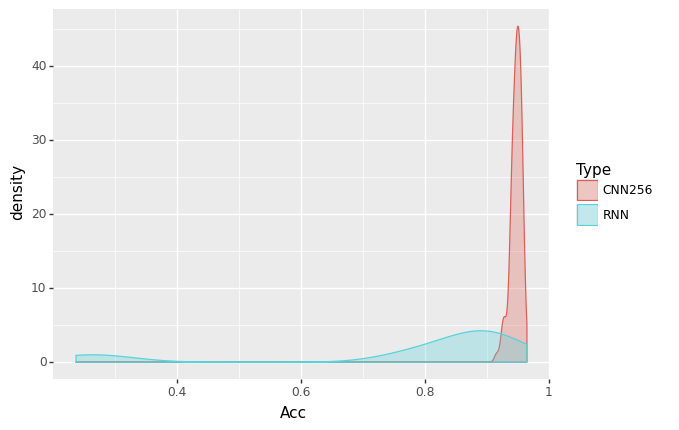

<ggplot: (8771474425529)>

In [ ]:
ggplot(indiv_accs, aes(x='Acc',color='Type', fill='Type')) + geom_density(alpha = 0.3)

# Show ensemble CNN/RNN/CNN&RNN

In [ ]:
os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")

['temp',
 'individual_cnn_summary_20211206214644.npy',
 'individual_rnn_summary_20211207160708.npy',
 'ensemble_rnn_test_results_20211207213341.csv',
 'ensemble_cnn_test_results_20211207215955.csv',
 'cnn_rnn_ensemble_contour_data_20211207233449.csv',
 'cnn_rnn_ensemble_contour_data_20211207235706.csv',
 'rnn_collab_test_results_lc0_20211219152718.csv',
 'rnn_collab_test_results_lc1_20211219153447.csv',
 'cnn_collab_test_results_lc0_20211219154947.csv',
 'cnn_collab_test_results_lc1_20211219155723.csv',
 'cnn_rnn_contour_data_20220103002929.csv',
 'cnn_rnn_sftmx_contour_data_20220105013257.csv']

In [ ]:
ensemble_rnns = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/ensemble_rnn_test_results_20211207213341.csv")
ensemble_cnns = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/ensemble_cnn_test_results_20211207215955.csv")
ensemble_cnnrnnss = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_rnn_ensemble_contour_data_20211207235706.csv")

In [ ]:
ensemble_cnns["CNN%"] = np.select([ensemble_cnns.Type=="CNN256",ensemble_cnns.Type=="RNN"],[1.0,0.0])
ensemble_rnns["CNN%"] = np.select([ensemble_rnns.Type=="CNN256",ensemble_rnns.Type=="RNN"],[1.0,0.0])


In [ ]:
ensemble_cnnrnnss = ensemble_cnnrnnss.drop_duplicates()
ensemble_cnnrnnss["NumOfModels"] = ensemble_cnnrnnss.NumOfA + ensemble_cnnrnnss.NumOfB
ensemble_cnnrnnss["Type"] = "CNN_RNN"
ensemble_cnnrnnss["CNN%"] = ensemble_cnnrnnss.NumOfA/ensemble_cnnrnnss["NumOfModels"]

In [ ]:
# ensemble_rnns

In [ ]:
ensemble_data = pd.concat([ ensemble_rnns[["Type","Data","NumOfModels","CNN%","Pr","Rc","F1","Acc"]],
            ensemble_cnns[["Type","Data","NumOfModels","CNN%","Pr","Rc","F1","Acc"]],
            ensemble_cnnrnnss[["Type","Data","NumOfModels","CNN%","Pr","Rc","F1","Acc"]] ]).drop_duplicates()

In [ ]:
ensemble_data.loc[(ensemble_data["CNN%"] >= 1.0) & (ensemble_data["NumOfModels"]>=20),["NumOfModels","Pr","Rc","F1","Acc"]]

,NumOfModels,Pr,Rc,F1,Acc
70,20,0.960386,0.959207,0.959405,0.959207
71,20,0.956702,0.955711,0.955703,0.955711
72,22,0.957807,0.956876,0.957092,0.956876
73,22,0.963952,0.962704,0.962990,0.962704
74,25,0.964572,0.963869,0.964025,0.963869
75,25,0.963641,0.962704,0.962919,0.962704
76,30,0.963598,0.962704,0.962878,0.962704
77,30,0.960497,0.959207,0.959534,0.959207
78,35,0.961246,0.960373,0.960547,0.960373
79,35,0.965308,0.963869,0.964177,0.963869


In [ ]:
( np.array(ensemble_data.loc[(ensemble_data["CNN%"] >= 1.0) & (ensemble_data["NumOfModels"]==20),["NumOfModels","Pr","Rc","F1","Acc"]].mean(axis=0)) , 
  np.array(ensemble_data.loc[(ensemble_data["CNN%"] >= 1.0) & (ensemble_data["NumOfModels"]==40),["NumOfModels","Pr","Rc","F1","Acc"]].mean(axis=0)) )

(array([20.        ,  0.95854428,  0.95745921,  0.95755402,  0.95745921]),
 array([40.        ,  0.95979251,  0.95862471,  0.95883819,  0.95862471]))

In [ ]:
np.array(ensemble_data.loc[(ensemble_data["CNN%"] == 0.0) & (ensemble_data["NumOfModels"]==12),["NumOfModels","Pr","Rc","F1","Acc"]]).mean(axis=0)

array([12.        ,  0.92936153,  0.92657343,  0.92470842,  0.92657343])

In [ ]:
np.array(ensemble_data.loc[(ensemble_data["CNN%"] == 0.5) & (ensemble_data["NumOfModels"]==12),["NumOfModels","Pr","Rc","F1","Acc"]]).mean(axis=0)

array([12.        ,  0.96461972,  0.96386946,  0.96385723,  0.96386946])

In [ ]:
ensemble_data

,Type,Data,NumOfModels,CNN%,Pr,Rc,F1,Acc
0,RNN,Test,2,0.000000,0.920287,0.912587,0.911230,0.912587
1,RNN,Test,2,0.000000,0.916186,0.909091,0.906073,0.909091
2,RNN,Test,2,0.000000,0.934713,0.933566,0.932590,0.933566
3,RNN,Test,2,0.000000,0.905270,0.903263,0.900486,0.903263
4,RNN,Test,3,0.000000,0.914445,0.909091,0.905794,0.909091
...,...,...,...,...,...,...,...,...
1313,CNN_RNN,Test,12,0.500000,0.964240,0.963869,0.963751,0.963869
1314,CNN_RNN,Test,12,0.416667,0.959278,0.958042,0.957790,0.958042
1315,CNN_RNN,Test,12,0.333333,0.962231,0.961538,0.961550,0.961538
1316,CNN_RNN,Test,12,0.250000,0.955570,0.953380,0.953277,0.953380


In [ ]:
pure_rnn_ensembles  =  ensemble_data[ensemble_data['CNN%']==0.0].copy()
pure_cnn_ensembles  =  ensemble_data[ensemble_data['CNN%']==1.0].copy()

pure_rnn_ensembles.Type = "RNN"
pure_cnn_ensembles.Type = "CNN"


In [ ]:
pure_rnn_ensembles.Acc = pure_rnn_ensembles.groupby('NumOfModels').Acc.transform('mean')
pure_cnn_ensembles.Acc = pure_cnn_ensembles.groupby('NumOfModels').Acc.transform('mean')

pure_rnn_ensembles = pure_rnn_ensembles.drop_duplicates()
pure_cnn_ensembles = pure_cnn_ensembles.drop_duplicates()

pure_ensembles = pd.concat([pure_rnn_ensembles, pure_cnn_ensembles])


In [ ]:
indiv_cnns

array([[0.94193022, 0.93939394, 0.93971312, 0.93939394],
       [0.95723411, 0.95454545, 0.95475674, 0.95454545],
       [0.95024615, 0.94755245, 0.9481423 , 0.94755245],
       [0.95022874, 0.94755245, 0.94811094, 0.94755245],
       [0.9564547 , 0.95337995, 0.95346573, 0.95337995],
       [0.93077229, 0.92424242, 0.92472829, 0.92424242],
       [0.9514335 , 0.94988345, 0.95018328, 0.94988345],
       [0.95740258, 0.95687646, 0.95690019, 0.95687646],
       [0.9563528 , 0.95337995, 0.95369607, 0.95337995],
       [0.96083311, 0.96037296, 0.96043625, 0.96037296],
       [0.9403449 , 0.93706294, 0.93698478, 0.93706294],
       [0.94491318, 0.94055944, 0.94131336, 0.94055944],
       [0.95371493, 0.95221445, 0.95214988, 0.95221445],
       [0.9439904 , 0.94172494, 0.94140695, 0.94172494],
       [0.95511768, 0.95337995, 0.95386427, 0.95337995],
       [0.94275591, 0.93939394, 0.93971485, 0.93939394],
       [0.9495323 , 0.94522145, 0.94557079, 0.94522145],
       [0.96012306, 0.95687646,

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



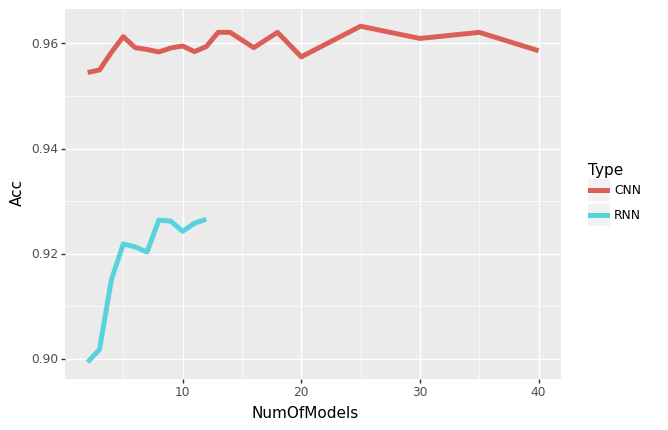

<ggplot: (8771462605237)>

In [ ]:
ggplot(pure_ensembles, aes(x='NumOfModels',y='Acc')) + geom_line(aes(group='Type',color='Type',fill='Type'), size=2)

# Show fully integrated models

In [ ]:
# os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals")

In [ ]:
cnn20_par = load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/ParallelCNN_A_20211209020220_saved_model_after_fit")



In [ ]:
cnn2_par = load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/ParallelCNN_A2_20211209133850_saved_model_after_fit")

In [ ]:
cnn1rnn1_par = load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/ParallelCNNRNN_A2_20211210221624_saved_model_after_fit")

In [ ]:
cnn20_par_y_predict_here = np.array(cnn20_par.predict(X_test_1000e), dtype='float64')
cnn20_par_y_predict_here = np.apply_along_axis(np.argmax, 1, cnn20_par_y_predict_here)
pr_rc_f1_acc_from_supplied(cnn20_par_y_predict_here, np.apply_along_axis(np.argmax, 1, Y_test_1000e))


KeyboardInterrupt: ignored

In [ ]:
cnn2_par_y_predict_here = np.array(cnn2_par.predict(X_test_1000e), dtype='float64')
cnn2_par_y_predict_here = np.apply_along_axis(np.argmax, 1, cnn2_par_y_predict_here)
pr_rc_f1_acc_from_supplied(cnn2_par_y_predict_here, np.apply_along_axis(np.argmax, 1, Y_test_1000e))

In [ ]:
cnn1rnn1_par_y_predict_here = np.array(cnn1rnn1_par.predict(X_test_1000e), dtype='float64')
cnn1rnn1_par_y_predict_here = np.apply_along_axis(np.argmax, 1, cnn1rnn1_par_y_predict_here)
pr_rc_f1_acc_from_supplied(cnn1rnn1_par_y_predict_here, np.apply_along_axis(np.argmax, 1, Y_test_1000e))

# Set up the models + features file lists for CNN/RNN splits for reuse test13

In [ ]:
acceptable_string_grabs = [ "CNN256_A_", "RNN_A_"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]
rnn_model_dirs = [ s for s in model_dirs if "RNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_model_dirs = [ s for s in model_dirs if "CNN256" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]

rnn_features_files = [ s for s in model_features_files if "RNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_features_files = [ s for s in model_features_files if "CNN256" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

cnn_identifier = acceptable_string_grabs[0]
rnn_identifier = acceptable_string_grabs[1]

def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  




# Set up data and functions




In [ ]:
time_map = { "RNN" : 131400.0, "CNN" : 390.0, 
           "Ensemble":  1.0, "Softmax" : 22.0, "Softmax_Unit": 10.0, "LastDense": 25.0, "LastDense_Unit": 10.0,
           "Integrated20CNN" : 4502.0, "Integrated2CNN" : 456.0, "Integrate1CNN1RNN": 149400.0,
              }

In [ ]:
import pandas as pd

def get_validation_acc_from_history_file(f1):
  pd1 = pd.read_csv(f1)
  return pd1[pd1.epoch==max(pd1.epoch)].val_sparse_categorical_accuracy.iloc[0]


In [ ]:
os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")

['temp',
 'individual_cnn_summary_20211206214644.npy',
 'individual_rnn_summary_20211207160708.npy',
 'ensemble_rnn_test_results_20211207213341.csv',
 'ensemble_cnn_test_results_20211207215955.csv',
 'cnn_rnn_ensemble_contour_data_20211207233449.csv',
 'cnn_rnn_ensemble_contour_data_20211207235706.csv',
 'rnn_collab_test_results_lc0_20211219152718.csv',
 'rnn_collab_test_results_lc1_20211219153447.csv',
 'cnn_collab_test_results_lc0_20211219154947.csv',
 'cnn_collab_test_results_lc1_20211219155723.csv',
 'cnn_rnn_contour_data_20220103002929.csv',
 'cnn_rnn_sftmx_contour_data_20220105013257.csv']

In [ ]:
# get ensemble data
all_ensemble_data =  pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}").reset_index(drop=True) for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results") if "ensemble" in f and ".csv" in f and "contour" not in f])
all_ensemble_data = all_ensemble_data.drop_duplicates() 
all_ensemble_data = all_ensemble_data[["Type","Data", "NumOfModels",	"RepC"	,"Pr", "Rc",	"F1" , "Acc"]]
all_ensemble_data["Layer"] = "Ensemble"
all_ensemble_data.loc[all_ensemble_data.Type == "CNN256", ['Type']] = "CNN"

In [ ]:
# get collab data from last dense
all_lastdense_collab_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") 
                                        for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "collab_test" in f and "_lc0_" in f ])
all_lastdense_collab_data = all_lastdense_collab_data.drop_duplicates()
all_lastdense_collab_data["Layer"] = "LastDense"
all_lastdense_collab_data.loc[all_lastdense_collab_data.Type == "CNN256", ['Type']] = "CNN"


In [ ]:
# get collab data from softmax
all_sftmx_collab_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") 
                                    for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "collab_test_" in f and "_lc1_" in f])
all_sftmx_collab_data = all_sftmx_collab_data.drop_duplicates()
all_sftmx_collab_data["Layer"] = "Softmax"
all_sftmx_collab_data.loc[all_sftmx_collab_data.Type == "CNN256", ['Type']] = "CNN"


In [ ]:
# get all contour data
all_contour_data =  pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}").reset_index(drop=True) for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results") if ".csv" in f and "contour" in f])
all_contour_data = all_contour_data.drop_duplicates() 
all_contour_data.loc[all_contour_data.TypeA == "CNN256", ['TypeA']] = "CNN"
all_contour_data.loc[all_contour_data.Layer!="Ensemble","Layer"] = "Softmax"


In [ ]:
all_ensemble_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/all_e.csv")
all_lastdense_collab_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/all_clld.csv")
all_sftmx_collab_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/all_clsf.csv")
all_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/all_c.csv")

# Regressions

In [ ]:
%%R

install.packages(c("foreach"), quiet=TRUE, verbose=FALSE)
install.packages(c("RColorBrewer","ggplot2","ggthemes"), quiet=TRUE, verbose=FALSE)


R[write to console]: also installing the dependency ‘iterators’




In [ ]:
%%R -i paper_name

require(data.table)

list.files()
ensembleData = fread(paste("/content/drive/MyDrive/data_papers/",paper_name,"/model_ccs/all_e.csv",sep=""))
contourData = fread(paste("/content/drive/MyDrive/data_papers/",paper_name,"/model_ccs/all_c.csv",sep=""))
clSftmxData = fread(paste("/content/drive/MyDrive/data_papers/",paper_name,"/model_ccs/all_clsf.csv",sep=""))
clLstDnData = fread(paste("/content/drive/MyDrive/data_papers/",paper_name,"/model_ccs/all_clld.csv",sep=""))

ensembleData[,Pr:=NULL]
ensembleData[,Rc:=NULL]
ensembleData[,F1:=NULL]
ensembleData[,RepC:=NULL]
ensembleData[,V1:=NULL]

clSftmxData[,Pr:=NULL]
clSftmxData[,Rc:=NULL]
clSftmxData[,F1:=NULL]
clSftmxData[,RepC:=NULL]
clSftmxData[,V1:=NULL]
clSftmxData[,`Unnamed: 0`:=NULL]

clLstDnData[,Pr:=NULL]
clLstDnData[,Rc:=NULL]
clLstDnData[,F1:=NULL]
clLstDnData[,RepC:=NULL]
clLstDnData[,V1:=NULL]
clLstDnData[,`Unnamed: 0`:=NULL]

contourData[,Pr:=NULL]
contourData[,Rc:=NULL]
contourData[,F1:=NULL]
contourData[,RepC:=NULL]
contourData[,V1:=NULL]
contourData[,`Unnamed: 0`:=NULL]

head(contourData,4)


R[write to console]: Loading required package: data.table

R[write to console]: data.table 1.14.2 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com



   TypeA TypeB Data    Layer NumOfA NumOfB       Acc
1:   CNN   RNN Test Ensemble      2      0 0.9627040
2:   CNN   RNN Test Ensemble      1      1 0.9662005
3:   CNN   RNN Test Ensemble      0      2 0.8123543
4:   CNN   RNN Test Ensemble      2      0 0.9627040


In [ ]:
%%R

require(dplyr)

ensembleData = ensembleData %>% mutate( NumOfCNN = ifelse(Type=="CNN", NumOfModels, 0), 
                                        NumOfRNN = ifelse(Type=="RNN", NumOfModels, 0))

clSftmxData = clSftmxData %>% mutate( NumOfCNN = ifelse(Type=="CNN", NumOfModels, 0), 
                                        NumOfRNN = ifelse(Type=="RNN", NumOfModels, 0))

clLstDnData = clLstDnData %>% mutate( NumOfCNN = ifelse(Type=="CNN", NumOfModels, 0), 
                                        NumOfRNN = ifelse(Type=="RNN", NumOfModels, 0))

contourData = contourData %>% mutate( NumOfCNN = ifelse(TypeA=="CNN", NumOfA, ifelse(TypeB=="CNN",NumOfB, 0)), 
                                      NumOfRNN = ifelse(TypeA=="RNN", NumOfA, ifelse(TypeB=="RNN",NumOfB, 0)))



R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:data.table’:

    between, first, last


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
%%R
head(contourData,4)

   TypeA TypeB Data    Layer NumOfA NumOfB       Acc NumOfCNN NumOfRNN
1:   CNN   RNN Test Ensemble      2      0 0.9627040        2        0
2:   CNN   RNN Test Ensemble      1      1 0.9662005        1        1
3:   CNN   RNN Test Ensemble      0      2 0.8123543        0        2
4:   CNN   RNN Test Ensemble      2      0 0.9627040        2        0


In [ ]:
%%R

alld = rbindlist(  list ( ensembleData[,.(Acc, Layer, NumOfCNN, NumOfRNN)],
                          clSftmxData[,.(Acc, Layer, NumOfCNN, NumOfRNN)],
                          clLstDnData[,.(Acc, Layer, NumOfCNN, NumOfRNN)],
                          contourData[,.(Acc, Layer, NumOfCNN, NumOfRNN)] )
              )

alld = alld %>% mutate(sqNumOfCNN = NumOfCNN*NumOfCNN, sqNumOfRNN = NumOfRNN*NumOfRNN)  

require(foreach)
require(data.table)


reg5 = lm(data=alld[alld$Layer == "Softmax"] , log(Acc) ~ NumOfCNN + NumOfRNN + sqNumOfCNN + sqNumOfRNN  + (NumOfCNN + NumOfRNN )^2  ) 
summary(reg5)

# reg1 = lm(data=alld , Acc ~ NumOfCNN + NumOfRNN + as.factor(Layer)) 
# print(summary(reg1)$adj.r.squared)

# reg2 = lm(data=alld , log(Acc) ~ NumOfCNN + NumOfRNN  + as.factor(Layer)) 
# print(summary(reg2)$adj.r.squared)

# reg3 = lm(data=alld , log(Acc) ~ NumOfCNN + NumOfRNN  + as.factor(Layer) + (NumOfCNN + NumOfRNN  + as.factor(Layer) )^2  ) 
# print(summary(reg3)$adj.r.squared)
# print(summary(reg3))

# reg4 = lm(data=alld , log(Acc) ~ NumOfCNN + NumOfRNN  + sqNumOfCNN + sqNumOfRNN + as.factor(Layer) + (NumOfCNN + NumOfRNN  + as.factor(Layer) )^2  ) 
# print(summary(reg4)$adj.r.squared)
# print(summary(reg4))


R[write to console]: Loading required package: foreach




Call:
lm(formula = log(Acc) ~ NumOfCNN + NumOfRNN + sqNumOfCNN + sqNumOfRNN + 
    (NumOfCNN + NumOfRNN)^2, data = alld[alld$Layer == "Softmax"])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.113385 -0.004011  0.000578  0.005293  0.022410 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -4.465e-02  1.270e-03 -35.153  < 2e-16 ***
NumOfCNN           6.527e-04  1.876e-04   3.479 0.000526 ***
NumOfRNN          -6.049e-04  4.919e-04  -1.230 0.219081    
sqNumOfCNN        -1.409e-05  4.247e-06  -3.317 0.000942 ***
sqNumOfRNN         1.050e-04  3.912e-05   2.683 0.007419 ** 
NumOfCNN:NumOfRNN  4.418e-04  4.940e-05   8.943  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.009297 on 974 degrees of freedom
Multiple R-squared:  0.2492,	Adjusted R-squared:  0.2453 
F-statistic: 64.65 on 5 and 974 DF,  p-value: < 2.2e-16



In [ ]:
%%R

fwrite(alld, paste("/content/drive/MyDrive/data_papers/",paper_name,"/model_ccs/alld_fromR.csv",sep=""))

# CCA/PCA1 analysis

In [ ]:
import random
import re
from collections import defaultdict

def get_base_patterns_for_validation_on_layer_count(features_files, layer_count = 0, layer_name = "dense", model_type = "RNN"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files ]:
    validation_search = re.search(f'^.*({model_type}_.*features_{layer_name}_.*)_Train_X.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  id_matches = [ (f, re.search(f'(.*)({layer_name}_[\d]+).*', f, re.IGNORECASE)) for f in base_patterns_for_validations ]
  id_matches =  [ (f, f[1].group(1), int(f[1].group(2).split("_")[1])) for f in id_matches if f[1] ]

  base_pattern_to_layer = defaultdict(list)

  for full_pattern, base_pattern, model_layer_count in id_matches:
    if base_pattern_to_layer[base_pattern]:
      base_pattern_to_layer[base_pattern].append(model_layer_count)
      base_pattern_to_layer[base_pattern] = sorted(base_pattern_to_layer[base_pattern])
    else:
      base_pattern_to_layer[base_pattern] = [model_layer_count]

  return [ f"{base_pattern}{layer_name}_{layer_numbers[min(layer_count,len(layer_numbers)-1)]}_" for base_pattern, layer_numbers in base_pattern_to_layer.items()]


def get_base_patterns_dict(features_files, layer_name = "dense", model_type = "RNN"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files ]:
    validation_search = re.search(f'^.*({model_type}_.*features_{layer_name}_.*)_Train_X.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  id_matches = [ (f, re.search(f'(.*)({layer_name}_[\d]+).*', f, re.IGNORECASE)) for f in base_patterns_for_validations ]
  id_matches =  [ (f, f[1].group(1), int(f[1].group(2).split("_")[1])) for f in id_matches if f[1] ]

  base_pattern_to_layer = defaultdict(list)

  for full_pattern, base_pattern, model_layer_count in id_matches:
    if base_pattern_to_layer[base_pattern]:
      base_pattern_to_layer[base_pattern].append(model_layer_count)
      base_pattern_to_layer[base_pattern] = sorted(base_pattern_to_layer[base_pattern])
    else:
      base_pattern_to_layer[base_pattern] = [model_layer_count]  
  
  return base_pattern_to_layer

In [ ]:
file_to_layers_dict = {**get_base_patterns_dict(rnn_features_files, model_type = "RNN"), **get_base_patterns_dict(cnn_features_files, model_type = "CNN256")}

In [ ]:
def get_layer_name_of_file(f1name,file_to_layers_dict, layer_prefix="dense_"):  
  for k in list(file_to_layers_dict.keys()):
    if k in f1name:
      full_layer_names_to_match = [f"_{layer_prefix}{str(v)}_" for v in file_to_layers_dict[k] ]
      for idx, val in enumerate(full_layer_names_to_match):
        if val in f1name:
          if idx == (len(full_layer_names_to_match)-1):
            return "SFTMX"
      else:
        return "PREVDL"

In [ ]:
pca1_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/{ff}", index_col=0, sep=",") for ff in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/") if "all_Validation" in ff])
pca1_data = pca1_data[~np.isnan(pca1_data.PCA1)]

In [ ]:
import math
pca1_data["TypeF1"] = [ "".join([ c for c in f1name.split("/model_features/")[1].split("_")[0] if not c.isdigit() ]).replace("-","") for f1name in pca1_data.f1.tolist() ] 
pca1_data["TypeF2"] = [ "".join([ c for c in f2name.split("/model_features/")[1].split("_")[0] if not c.isdigit() ]).replace("-","") for f2name in pca1_data.f2.tolist() ] 

pca1_data["TypeCombination"] = [ "_".join(sorted([x,y])) for x,y in zip(pca1_data["TypeF1"],pca1_data["TypeF2"]) ]  

pca1_data["LayerF1"] = [ get_layer_name_of_file(x, file_to_layers_dict) for x in pca1_data.f1.tolist() ] 
pca1_data["LayerF2"] = [ get_layer_name_of_file(x, file_to_layers_dict) for x in pca1_data.f2.tolist() ] 

# [ "".join([ c for c in f1name.split("_features_")[1].split("_Validation")[0].replace("CLASSIFIER_","") ]).replace("-","") for f1name in pca1_data.f1.tolist() ] 
# pca1_data["LayerF2"] = [ "".join([ c for c in f2name.split("_features_")[1].split("_Validation")[0].replace("CLASSIFIER_","") ]).replace("-","") for f2name in pca1_data.f2.tolist() ] 

pca1_data["LayerCombination"] = [ "_".join(sorted([x,y])) for x,y in zip(pca1_data["LayerF1"],pca1_data["LayerF2"]) ]    

pca1_data["PCA1ABS"] = np.abs(pca1_data.PCA1)

pca1_data["AvgPCA1Perc"] = (pca1_data.PercPCA1F1+pca1_data.PercPCA1F2)/2.0
pca1_data["DeltaPCA1Perc"] = np.abs(pca1_data.PercPCA1F1-pca1_data.PercPCA1F2)

In [ ]:
# pd.DataFrame(pca1_data.groupby(["TypeCombination"]).PCA1.mean())
# pd.DataFrame(pca1_data.groupby(["TypeCombination","LayerCombination"]).PCA1.mean())

# pd.DataFrame(pca1_data.groupby(["TypeCombination"])["CCA","PCA1","AvgPCA1Perc","DeltaPCA1Perc"].mean())
pd.DataFrame(pca1_data.groupby(["TypeCombination","LayerCombination"])["CCA","PCA1ABS","AvgPCA1Perc","DeltaPCA1Perc"].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



CCA  ...  DeltaPCA1Perc
TypeCombination LayerCombination            ...               
CNN_CNN         PREVDL_PREVDL     0.995434  ...       0.011149
                PREVDL_SFTMX      0.983734  ...       0.098490
                SFTMX_SFTMX       0.999987  ...       0.000098
CNN_RNN         PREVDL_PREVDL     0.979451  ...       0.092710
                PREVDL_SFTMX      0.952790  ...       0.140181
                SFTMX_SFTMX       0.956989  ...       0.051117
RNN_RNN         PREVDL_PREVDL     0.976784  ...       0.103405
                PREVDL_SFTMX      0.938200  ...       0.163702
                SFTMX_SFTMX       0.928819  ...       0.075242

[9 rows x 4 columns]

In [ ]:
cca_pca1_df = pd.DataFrame(pca1_data.groupby(["TypeCombination","LayerCombination"])["CCA","PCA1ABS","AvgPCA1Perc","DeltaPCA1Perc"].mean())
cca_pca1_df.reset_index(inplace=True)
#cca_pca1_df.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/cca_pca1_df_1.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
cca_pca1_df_basic = pd.DataFrame(pca1_data.groupby(["TypeCombination"])["CCA","PCA1ABS","AvgPCA1Perc","DeltaPCA1Perc"].mean())
cca_pca1_df_basic.reset_index(inplace=True)
#cca_pca1_df_basic.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/cca_pca1_df_1_basic.csv")

time: 14.3 ms (started: 2022-01-12 16:20:11 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



# Energy Analysis

In [ ]:
all_contour_data.head(4)

,Unnamed: 0,TypeA,TypeB,Data,Layer,NumOfA,NumOfB,RepC,Pr,Rc,F1,Acc
0,0,CNN,RNN,Test,Ensemble,2,0,0,0.963543,0.962704,0.962886,0.962704
1,1,CNN,RNN,Test,Ensemble,1,1,0,0.966778,0.966200,0.965936,0.966200
2,2,CNN,RNN,Test,Ensemble,0,2,0,0.842391,0.812354,0.803093,0.812354
3,3,CNN,RNN,Test,Ensemble,2,0,1,0.963413,0.962704,0.962758,0.962704


In [ ]:
alld = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/alld_fromR.csv")

In [ ]:
# alld.Layer.unique()
alld.head(4)

,Acc,Layer,NumOfCNN,NumOfRNN,sqNumOfCNN,sqNumOfRNN
0,0.912587,Ensemble,0,2,0,4
1,0.909091,Ensemble,0,2,0,4
2,0.933566,Ensemble,0,2,0,4
3,0.903263,Ensemble,0,2,0,4


In [ ]:
time_map

{'CNN': 390.0,
 'Ensemble': 1.0,
 'Integrate1CNN1RNN': 149400.0,
 'Integrated20CNN': 4502.0,
 'Integrated2CNN': 456.0,
 'LastDense': 25.0,
 'LastDense_Unit': 10.0,
 'RNN': 131400.0,
 'Softmax': 22.0,
 'Softmax_Unit': 10.0}

In [71]:
def time_used_test13(numOfCNN, numOfRNN, layer, time_map):
  total_time = 0.0
  if layer in time_map.keys():
    total_time += numOfCNN * time_map["CNN"] + numOfRNN * time_map["RNN"]
    if layer == "Ensemble":
      total_time += time_map[layer]
    elif (layer == "LastDense") | (layer == "Softmax"):
      total_time += (numOfCNN+numOfRNN)*(time_map[layer]/time_map[f"{layer}_Unit"])
  return total_time


In [83]:
# alld['timeUsed'] = alld.apply(lambda row : time_used(row['TypeA'],r ow['NumOfA'],row['TypeB'],row['NumOfB'], row['Layer'], time_map), axis = 1)
# test = alld.head(4).apply(lambda row : time_used(row['TypeA'],row['NumOfA'],row['TypeB'],row['NumOfB'], row['Layer'], time_map), axis = 1)
alld['timeUsed'] = alld.apply(lambda row : time_used_test13(row['NumOfCNN'],row['NumOfRNN'], row['Layer'], time_map), axis = 1)
alld['logAcc'] = np.log(alld.Acc)
alld['CNNPerc'] = alld['NumOfCNN']/(alld['NumOfCNN']+alld['NumOfRNN']) 

In [99]:
# alld['CNNPerc'].unique()

alld['CNNPercBucket'] = pd.cut(alld['CNNPerc'], [ round(0.1 + x*0.1,1) for x in range(10)], precision=0.1, labels=["0-10%","10-20%","20-30%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"])
alld['CNNPercBucket'] = alld['CNNPercBucket'].fillna("0-10%")

In [105]:
alld.sample(8).sort_index()
alld.shape

(2922, 10)

In [132]:
alldSummary = alld.groupby(['Layer','NumOfCNN','NumOfRNN'])['Acc','timeUsed'].mean()
alldSummary.reset_index(inplace=True)
alldSummary['logAcc'] = np.log(alldSummary.Acc)
alldSummary['CNNPerc'] = alldSummary['NumOfCNN']/(alldSummary['NumOfCNN']+alldSummary['NumOfRNN']) 
alldSummary['CNNPercBucket'] = pd.cut(alldSummary['CNNPerc'], [ round(0.1 + x*0.1,1) for x in range(10)], precision=0.1, labels=["0-10%","10-20%","20-30%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"])
alldSummary['CNNPercBucket'] = alldSummary['CNNPercBucket'].fillna("0-10%")
alldSummary['timeUsed'] = alldSummary['timeUsed']/3600.0 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [153]:
alldSummary.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/alldsummary_forR.csv")

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



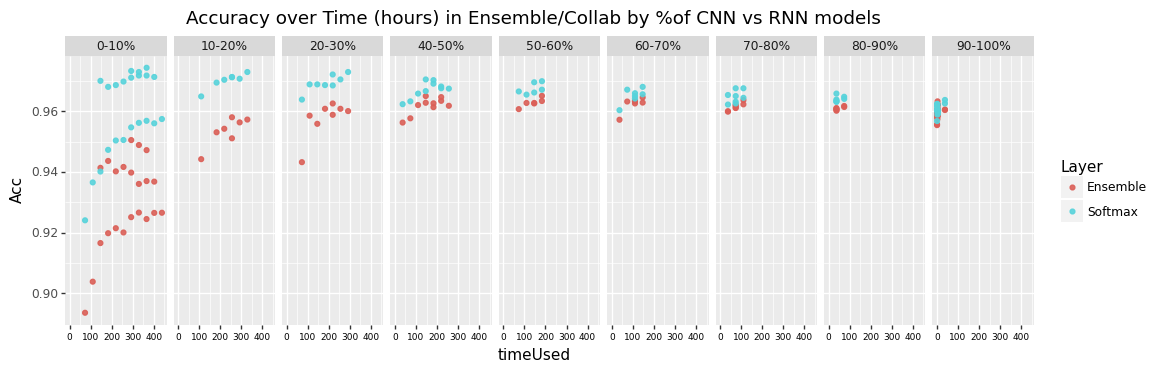

<ggplot: (8776258326713)>

In [143]:
from plotnine import *

# ggplot(alld, aes(x='timeUsed', y='Acc', groupby='Layer', color='Layer')) + geom_point() + facet_grid('.~CNNPercBucket')

ggplot(alldSummary[alldSummary.Layer!="LastDense"], aes(x='timeUsed', y='Acc', groupby='Layer', color='Layer')) + geom_point(alpha=0.9) + \
facet_grid('.~CNNPercBucket') + ggtitle("Accuracy over Time (hours) in Ensemble/Collab by %of CNN vs RNN models") + theme(figure_size = (12.5, 3.5)) + \
theme(axis_text_x=element_text(colour="black", size=6.5))


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



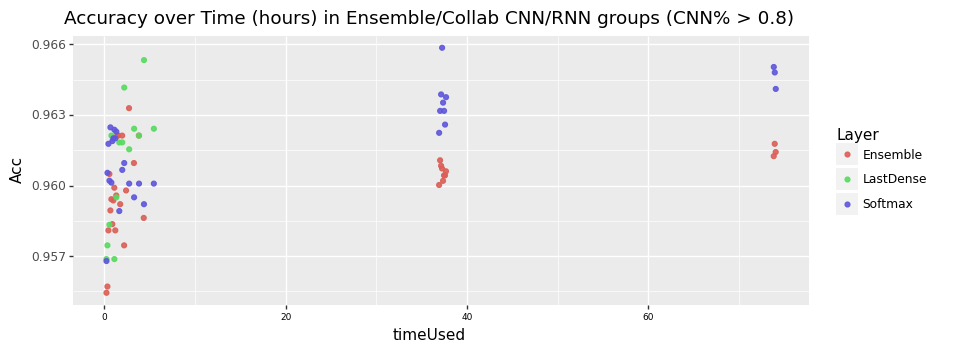

<ggplot: (8776254610869)>

In [152]:

ggplot(alldSummary[alldSummary.CNNPerc>=0.8], aes(x='timeUsed', y='Acc', groupby='Layer', color='Layer')) + geom_point(alpha=0.9) + \
ggtitle("Accuracy over Time (hours) in Ensemble/Collab CNN/RNN groups (CNN% > 0.8)") + theme(figure_size = (9.5, 3.5)) + \
theme(axis_text_x=element_text(colour="black", size=6.5))


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



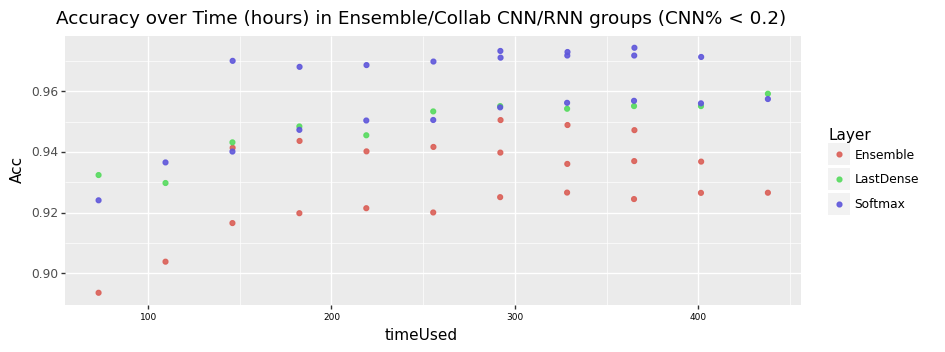

<ggplot: (8776254913645)>

In [151]:

ggplot(alldSummary[alldSummary.CNNPerc<=0.2], aes(x='timeUsed', y='Acc', groupby='Layer', color='Layer')) + geom_point(alpha=0.9) + \
ggtitle("Accuracy over Time (hours) in Ensemble/Collab CNN/RNN groups (CNN% < 0.2)") + theme(figure_size = (9.5, 3.5)) + \
theme(axis_text_x=element_text(colour="black", size=6.5))


In [158]:
%%R -i paper_name

alldSummary = fread( paste("/content/drive/MyDrive/data_papers/",paper_name,"/model_ccs/alldsummary_forR.csv",sep="") )
alldSummary[,V1:=NULL]
head(alldSummary,5)

      Layer NumOfCNN NumOfRNN       Acc  timeUsed      logAcc CNNPerc
1: Ensemble        0        2 0.8935995  73.00028 -0.11249764       0
2: Ensemble        0        3 0.9038462 109.50028 -0.10109612       0
3: Ensemble        0        4 0.9165695 146.00028 -0.08711734       0
4: Ensemble        0        5 0.9198232 182.50028 -0.08357377       0
5: Ensemble        0        6 0.9214744 219.00028 -0.08178033       0
   CNNPercBucket
1:         0-10%
2:         0-10%
3:         0-10%
4:         0-10%
5:         0-10%


In [166]:
%%R

# regA = lm(data=alldSummary, Acc ~ Layer + log(timeUsed) + NumOfCNN + NumOfRNN + CNNPerc)
# summary(regA)

regB = lm(data=alldSummary, Acc ~ Layer + log(timeUsed) + NumOfCNN + NumOfRNN + CNNPerc + (Layer + NumOfCNN + NumOfRNN + CNNPerc)^2)
summary(regB)




Call:
lm(formula = Acc ~ Layer + log(timeUsed) + NumOfCNN + NumOfRNN + 
    CNNPerc + (Layer + NumOfCNN + NumOfRNN + CNNPerc)^2, data = alldSummary)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0171692 -0.0022407  0.0003456  0.0024739  0.0122762 

Coefficients: (1 not defined because of singularities)
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              9.114e-01  3.165e-03 287.976  < 2e-16 ***
LayerLastDense           2.464e-02  3.971e-03   6.206 2.98e-09 ***
LayerSoftmax             2.736e-02  3.166e-03   8.642 1.61e-15 ***
log(timeUsed)           -1.501e-03  4.407e-04  -3.405 0.000797 ***
NumOfCNN                 2.503e-02  1.706e-03  14.667  < 2e-16 ***
NumOfRNN                 2.888e-03  2.958e-04   9.764  < 2e-16 ***
CNNPerc                  4.846e-02  3.449e-03  14.052  < 2e-16 ***
LayerLastDense:NumOfCNN  1.215e-04  1.158e-04   1.049 0.295602    
LayerSoftmax:NumOfCNN    4.475e-05  1.058e-04   0.423 0.672667    


In [168]:
%%R 

regC = lm(data=alldSummary, Acc ~ Layer + log(timeUsed) + NumOfCNN + NumOfRNN + CNNPerc + (NumOfCNN + NumOfRNN + CNNPerc)^2)
summary(regC)



Call:
lm(formula = Acc ~ Layer + log(timeUsed) + NumOfCNN + NumOfRNN + 
    CNNPerc + (NumOfCNN + NumOfRNN + CNNPerc)^2, data = alldSummary)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0271189 -0.0038646  0.0000628  0.0042799  0.0153982 

Coefficients: (1 not defined because of singularities)
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.9192854  0.0039719 231.446  < 2e-16 ***
LayerLastDense     0.0106252  0.0016184   6.565 4.00e-10 ***
LayerSoftmax       0.0105758  0.0009502  11.130  < 2e-16 ***
log(timeUsed)     -0.0009376  0.0006631  -1.414    0.159    
NumOfCNN           0.0229431  0.0025708   8.925 2.25e-16 ***
NumOfRNN           0.0027279  0.0003179   8.582 2.08e-15 ***
CNNPerc            0.0332893  0.0040969   8.126 3.79e-14 ***
NumOfCNN:NumOfRNN -0.0015688  0.0002093  -7.495 1.82e-12 ***
NumOfCNN:CNNPerc  -0.0228643  0.0025427  -8.992  < 2e-16 ***
NumOfRNN:CNNPerc          NA         NA      NA       NA    
---
Sig

In [169]:
%%R

regD = lm(data=alldSummary, Acc ~ log(timeUsed) + NumOfCNN + NumOfRNN + CNNPerc + (NumOfCNN + NumOfRNN + CNNPerc)^2)
summary(regD)



Call:
lm(formula = Acc ~ log(timeUsed) + NumOfCNN + NumOfRNN + CNNPerc + 
    (NumOfCNN + NumOfRNN + CNNPerc)^2, data = alldSummary)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.034121 -0.003313  0.000031  0.003118  0.019935 

Coefficients: (1 not defined because of singularities)
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.9269845  0.0049563 187.031  < 2e-16 ***
log(timeUsed)     -0.0010868  0.0008450  -1.286      0.2    
NumOfCNN           0.0219784  0.0032556   6.751 1.38e-10 ***
NumOfRNN           0.0026994  0.0004061   6.647 2.49e-10 ***
CNNPerc            0.0312745  0.0051994   6.015 7.79e-09 ***
NumOfCNN:NumOfRNN -0.0015076  0.0002660  -5.667 4.70e-08 ***
NumOfCNN:CNNPerc  -0.0218469  0.0032175  -6.790 1.11e-10 ***
NumOfRNN:CNNPerc          NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.008452 on 212 degrees of freedom
Multiple R-squared:

In [172]:
%%R
regE = lm(data=alldSummary, Acc ~ log(timeUsed) + Layer + CNNPerc)
summary(regE)



Call:
lm(formula = Acc ~ log(timeUsed) + Layer + CNNPerc, data = alldSummary)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.041463 -0.004338  0.000805  0.006017  0.017622 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.9163848  0.0034725 263.897  < 2e-16 ***
log(timeUsed)  0.0043534  0.0004942   8.809 4.36e-16 ***
LayerLastDense 0.0074090  0.0020209   3.666  0.00031 ***
LayerSoftmax   0.0105698  0.0012319   8.580 1.94e-15 ***
CNNPerc        0.0361679  0.0028659  12.620  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.008577 on 214 degrees of freedom
Multiple R-squared:  0.5346,	Adjusted R-squared:  0.5259 
F-statistic: 61.44 on 4 and 214 DF,  p-value: < 2.2e-16



In [185]:
%%R
regF = lm(data=alldSummary, Acc ~ log(timeUsed) + Layer + CNNPerc + NumOfRNN + NumOfCNN + (Layer + CNNPerc)^2)
summary(regF)



Call:
lm(formula = Acc ~ log(timeUsed) + Layer + CNNPerc + NumOfRNN + 
    NumOfCNN + (Layer + CNNPerc)^2, data = alldSummary)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0227278 -0.0042389  0.0006045  0.0041562  0.0136427 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             8.972e-01  2.939e-03 305.276  < 2e-16 ***
log(timeUsed)           3.528e-03  3.831e-04   9.209  < 2e-16 ***
LayerLastDense          1.806e-02  2.266e-03   7.971 9.91e-14 ***
LayerSoftmax            2.656e-02  1.674e-03  15.866  < 2e-16 ***
CNNPerc                 6.545e-02  3.092e-03  21.169  < 2e-16 ***
NumOfRNN                1.994e-03  2.581e-04   7.724 4.54e-13 ***
NumOfCNN               -1.828e-04  6.401e-05  -2.856  0.00472 ** 
LayerLastDense:CNNPerc -1.763e-02  3.130e-03  -5.631 5.70e-08 ***
LayerSoftmax:CNNPerc   -2.913e-02  2.592e-03 -11.240  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Resid

In [184]:
%%R
regF = lm(data=alldSummary, Acc ~ log(timeUsed) + Layer + CNNPerc + NumOfCNN + NumOfRNN + (NumOfCNN + log(timeUsed) + Layer + CNNPerc)^2)
summary(regF)



Call:
lm(formula = Acc ~ log(timeUsed) + Layer + CNNPerc + NumOfCNN + 
    NumOfRNN + (NumOfCNN + log(timeUsed) + Layer + CNNPerc)^2, 
    data = alldSummary)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0167235 -0.0027722 -0.0006348  0.0029235  0.0154620 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   8.404e-01  1.940e-02  43.322  < 2e-16 ***
log(timeUsed)                 1.613e-02  4.510e-03   3.577 0.000435 ***
LayerLastDense                3.811e-02  1.329e-02   2.868 0.004564 ** 
LayerSoftmax                  4.280e-02  3.877e-03  11.039  < 2e-16 ***
CNNPerc                       1.162e-01  1.966e-02   5.913 1.41e-08 ***
NumOfCNN                      9.573e-03  8.562e-04  11.181  < 2e-16 ***
NumOfRNN                     -5.134e-04  7.720e-04  -0.665 0.506774    
log(timeUsed):NumOfCNN       -6.118e-04  8.121e-05  -7.534 1.59e-12 ***
LayerLastDense:NumOfCNN       4.658e-04  1.994e-04   

In [2]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [3]:
import numpy as np
np.__version__

'1.19.5'

In [4]:
import pandas as pd
pd.__version__

'1.1.5'

In [5]:
import os,sys
sys.version_info

sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)

In [6]:
import scipy as sp
sp.__version__

'1.4.1'